## Bag Of Chars and MLP

In this section, we introduce two new concepts that will be used in conjunction. The first concept, **Bag of Chars**, serves as an alternative to the classic bigram approach discussed in the previous notebook. Unlike bigrams, which consider pairs of characters sequentially, **Bag of Chars** offers a more flexible technique for generating words.

### Explanation:

- **Bag of Chars:** This technique involves treating each character in a word as an independent entity, similar to how a bag of words model operates in natural language processing. Instead of focusing on character pairs (bigrams), we consider the frequency distribution and relationships between individual characters across words.
  
- **MLP (Multi-Layer Perceptron):** Alongside Bag of Chars, we employ an MLP for prediction and generation tasks. An MLP is a type of neural network architecture that consists of multiple layers of nodes (neurons), each layer fully connected to the next. It excels in learning complex patterns and relationships within data, which is advantageous when working with the flexible character representations provided by Bag of Chars.

By combining Bag of Chars with an MLP, we aim to enhance the flexibility and effectiveness of word generation models compared to traditional bigram approaches. This setup allows us to capture more nuanced dependencies between characters and generate more diverse and contextually appropriate sequences of characters or words.

In [2]:
from makemore.config import RAW_DATA_DIR, PROCESSED_DATA_DIR
print(f"RAW_DATA_DIR: {RAW_DATA_DIR}")
print(f"PROCESSED_DATA_DIR: {PROCESSED_DATA_DIR}")

2024-06-23 10:46:05.050 | INFO     | makemore.config:<module>:11 - PROJ_ROOT path is: /workspaces/makemore


RAW_DATA_DIR: /workspaces/makemore/data/raw
PROCESSED_DATA_DIR: /workspaces/makemore/data/processed


In [3]:
# Download the dataset
!python ../makemore/dataset.py

2024-06-23 10:46:06.701 | INFO     | makemore.config:<module>:11 - PROJ_ROOT path is: /workspaces/makemore
2024-06-23 10:46:06.710 | INFO     | __main__:main:22 - Downloading dataset...
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 47.44it/s]
2024-06-23 10:46:06.747 | INFO     | __main__:main:27 - namex.txt correctly download!


In [4]:
DATASET_NAME = "names.txt"

# Read words
with open(RAW_DATA_DIR / DATASET_NAME, "r") as names_file:
    names = names_file.readlines()

print(names[:10])

# Remove the \n from all the names
names = [name[:-1] for name in names]

names[:10]

['emma\n', 'olivia\n', 'ava\n', 'isabella\n', 'sophia\n', 'charlotte\n', 'mia\n', 'amelia\n', 'harper\n', 'evelyn\n']


['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [5]:
# Generate decoder and encoder for chars
chars = ".qwertyuiopasdfghjklzxcvbnm" # All available letters in latin alphabet plus .
decoder, encoder = {}, {}

for i, ch in enumerate(chars):
    encoder[ch] = i
    decoder[i] = ch

encoder, decoder  

({'.': 0,
  'q': 1,
  'w': 2,
  'e': 3,
  'r': 4,
  't': 5,
  'y': 6,
  'u': 7,
  'i': 8,
  'o': 9,
  'p': 10,
  'a': 11,
  's': 12,
  'd': 13,
  'f': 14,
  'g': 15,
  'h': 16,
  'j': 17,
  'k': 18,
  'l': 19,
  'z': 20,
  'x': 21,
  'c': 22,
  'v': 23,
  'b': 24,
  'n': 25,
  'm': 26},
 {0: '.',
  1: 'q',
  2: 'w',
  3: 'e',
  4: 'r',
  5: 't',
  6: 'y',
  7: 'u',
  8: 'i',
  9: 'o',
  10: 'p',
  11: 'a',
  12: 's',
  13: 'd',
  14: 'f',
  15: 'g',
  16: 'h',
  17: 'j',
  18: 'k',
  19: 'l',
  20: 'z',
  21: 'x',
  22: 'c',
  23: 'v',
  24: 'b',
  25: 'n',
  26: 'm'})

In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

First, we will attempt to understand the structure based on the image shown below. This is an MLP where the input consists of the three previous characters. The goal of the model is to predict the next character given a contextual block. These characters are first transformed into a vector space called embeddings, which is a crucial mathematical representation for Language Model (LM) tasks.

Once the characters are converted into embeddings, they are concatenated into a single vector. This vector serves as the input to a hidden layer, which then feeds into the output layer. The output layer has a size of 27, corresponding to the 27 available characters. The model uses a cross-entropy loss function to compute the probability distribution over these characters, predicting the most probable next character.

All the discussed parameters can be adjusted, and it is advisable not to hardcode them to allow for testing different configurations effectively.

### Parameters:
- Input size (number of previous characters)
- Embedding dimension
- Hidden layer size
- Output layer size (number of characters)
- Loss function (e.g., cross-entropy)
- Optimization algorithm and its parameters (e.g., learning rate)
- Number of training epochs
- Batch size
- Dropout rate (if used)
- Activation functions


![alt text](/home/linx/code_workspace/makemore/reports/figures/word_embedding.ppm)

We will start by building the dataset that we will use to train the model

In [7]:
# Context window dimension
context_size = 3 # As in the paper

# Store dataset
X, Y = [], []

for name in names:
    # Starting context
    context = [0] * context_size

    for ch in name:
        # Encode ch in an int
        i_ch = encoder[ch]
        # Store couple
        X.append(context)
        Y.append(i_ch)
        # Update context
        context = context[1:] + [i_ch]

    i_ch = encoder["."]
    X.append(context)
    Y.append(i_ch)

# Store dataset in torch tensor
X = torch.tensor(X)
Y = torch.tensor(Y)

print(f"Dataset lenght: {len(Y)}")

Dataset lenght: 228145


Always visualize of the data are correctly stored in the tensors

In [8]:
for prev, next in zip(X[:15], Y[:15]):
    prev_ch = [decoder[i.item()] for i in prev]
    next_ch = decoder[next.item()]

    print(f"{prev_ch} --> {next_ch}")

['.', '.', '.'] --> e
['.', '.', 'e'] --> m
['.', 'e', 'm'] --> m
['e', 'm', 'm'] --> a
['m', 'm', 'a'] --> .
['.', '.', '.'] --> o
['.', '.', 'o'] --> l
['.', 'o', 'l'] --> i
['o', 'l', 'i'] --> v
['l', 'i', 'v'] --> i
['i', 'v', 'i'] --> a
['v', 'i', 'a'] --> .
['.', '.', '.'] --> a
['.', '.', 'a'] --> v
['.', 'a', 'v'] --> a


Is noe the time to build out model. Best practice is to start from a forward with only a some data without using the backpropgation. This is done in order to understand if all computations are working correctly

In [9]:
# Embedding matrix: put chars in a vector space
embedding_dim = 2
C = torch.randn(27, embedding_dim)

# We now need to extract prev and next and convert the chars into the embeddings
n = 5
x_example, y_example = X[:n], Y[:n]

# Compute embeddings
embeddings = C[x_example]

# Concatenate embeddings of the same context
embeddings = embeddings.view((-1, embedding_dim * context_size))

# First hidden layer
W1 = torch.randn(embedding_dim * context_size, 100)
b1 = torch.randn(100)

out = (embeddings @ W1 + b1).tanh()

# Output layer
W2 = torch.randn(100, 27)
b2 = torch.randn(27)

out = out @ W2 + b2

# Compute loss
loss = F.cross_entropy(out, y_example)

Let's now train the network

In [10]:
# Hyperparameters
EPOCHS = 50000
lr = 0.1
embedding_dim = 30
hidden_layer_size = 100
batch_size = 32

In [11]:
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. GPU is ready for use.")
else:\
    print("CUDA is not available. Using CPU.")

CUDA is not available. Using CPU.


In [12]:
# Parameters
C = torch.randn(27, embedding_dim)
W1 = torch.randn(embedding_dim * context_size, hidden_layer_size)
b1 = torch.randn(hidden_layer_size)
W2 = torch.randn(hidden_layer_size, 27)
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [13]:
# Split the dataset
n1 = round(len(Y) * 0.80)
n2 = round(len(Y) * 0.90)

X_train, Y_train = X[:n1], Y[:n1]
X_val, Y_val = X[n1:n2], Y[n1:n2]
X_test, Y_test = X[n2], Y[n2:]

print(f"n1: {n1}, n2: {n2}")
print(f"Train lenght: {len(Y_train)}, Validation lenght: {len(Y_val)}, Test lenght: {len(Y_test)}")

n1: 182516, n2: 205330
Train lenght: 182516, Validation lenght: 22814, Test lenght: 22815


In [14]:
stats = {"epoch": [],
         "loss": [],
         "min_loss": 200,
         "best_model_params": []}

In [15]:
# Training
for epoch in range(EPOCHS):
    # Mini-batch
    i = torch.randint(low=0, high=Y_train.shape[0], size=(batch_size,))
    x_batch = X_train[i]
    y_batch = Y_train[i]

    # Forward
    emb = C[x_batch].view((-1, embedding_dim * context_size))
    out = (emb @ W1 + b1).tanh()
    out = out @ W2 + b2
    loss = F.cross_entropy(out, y_batch)

    # Set grad to zero
    for p in parameters:
        p.grad = None

    # Backpropagation
    loss.backward()

    # Update
    for p in parameters:
        lr = lr if epoch < 10000 else 0.001
        p.data -= lr * p.grad

    # Store stats
    stats["epoch"].append(epoch)
    stats["loss"].append(loss.item())
    if loss.item() < stats["min_loss"]:
        stats["min_loss"] = loss.item()
        stats["best_model_params"] = parameters 

print(f"Training loss: {loss}")

# Compute validation loss
emb = C[X_val].view((-1, embedding_dim * context_size))
out = (emb @ W1 + b1).tanh()
out = out @ W2 + b2
loss = F.cross_entropy(out, Y_val)
print(f"Validation loss: {loss}")

Training loss: 2.0884480476379395
Validation loss: 2.601353168487549


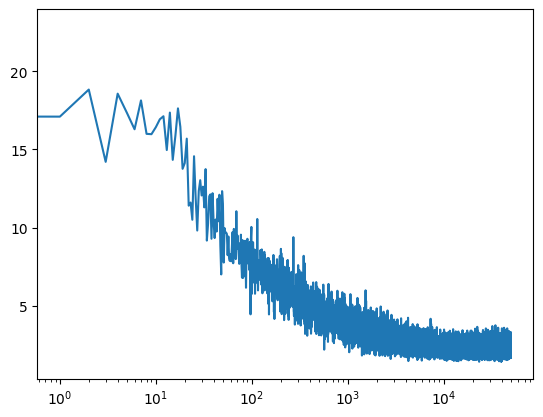

Min loss: 1.4096652269363403


In [16]:
plt.plot(stats["epoch"], stats["loss"])
plt.xscale("log")
plt.show()

print(f"Min loss: {stats['min_loss']}")

Is possible to test the model now

In [17]:
for p in parameters:
    p.requires_grad = False

In [18]:
# Load best model
for p, p_best in zip(parameters, stats["best_model_params"]):
    p = p_best

In [19]:
prev = [0] * context_size

for _ in range(20):
    while True:
        emb = C[torch.tensor(prev)].view((-1, embedding_dim * context_size))
        out = (emb @ W1 + b1).tanh()
        out = F.softmax(out @ W2 + b2, dim=1)
        next = torch.multinomial(out, num_samples=1)

        next_ch = decoder[next.item()]
        print(next_ch, end="")

        prev = prev[1:] + [next.item()]

        if next_ch == ".":
            print()
            break
    

tarshincleighmiaanlahylah.
ymaeiza.
tapsen.
thanelan.
hinahma.
pfah.
yrs.
cian.
guec.
cyle.
rayl.
pzeneh.
qwie.
taye.
lau.
aveyry.
ahnysila.
zer.
fae.
a.


# Golden Tips When Building a Model

Here I will explore some good data analysis techniques used when training a new model to optimize its performance.

Let's start with the initial error encountered during training. We can sometimes predict the type of error we will get when training a model. For example, we typically want to start with a uniform error during training. To achieve this, we want the parameters, especially in the last layer, to be correctly and uniformly distributed.

When a model is trained for the first time, the loss error is typically around 20. By reducing the values of the last weight and bias matrix, the error can be reduced. This is because the output of the last layer produces the so-called logits, which are first exponentiated to produce a matrix with counts. These counts are then normalized to get the probabilities. Thus, the values of the last layer are crucial, especially in the first iteration.

By multiplying \( W_2 \) by 0.01 and \( b_2 \) by 0, we can reduce the initial error to around 3, compared to 20 previously.

In [20]:
# Hyperparameters
EPOCHS = 1
lr = 0.01
embedding_dim = 30
hidden_layer_size = 100
batch_size = 32

In [21]:
# Parameters
C = torch.randn(27, embedding_dim)
W1 = torch.randn(embedding_dim * context_size, hidden_layer_size)
b1 = torch.randn(hidden_layer_size)
W2 = torch.randn(hidden_layer_size, 27)
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [22]:
# Training
for epoch in range(EPOCHS):
    # Mini-batch
    i = torch.randint(low=0, high=Y_train.shape[0], size=(batch_size,))
    x_batch = X_train[i]
    y_batch = Y_train[i]

    # Forward
    emb = C[x_batch].view((-1, embedding_dim * context_size))
    out = (emb @ W1 + b1).tanh()
    out = out @ W2 + b2
    loss = F.cross_entropy(out, y_batch)

    # Set grad to zero
    for p in parameters:
        p.grad = None

    # Backpropagation
    loss.backward()

    # Update
    for p in parameters:
        lr = lr if epoch < 10000 else 0.001
        p.data -= lr * p.grad

    print(f"Loss: {loss}")

Loss: 21.855318069458008


Apply Weight Initialization in the Last Layer

In [23]:
# Parameters
C = torch.randn(27, embedding_dim)
W1 = torch.randn(embedding_dim * context_size, hidden_layer_size)
b1 = torch.randn(hidden_layer_size)
W2 = torch.randn(hidden_layer_size, 27) * 0.01
b2 = torch.randn(27) * 0
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

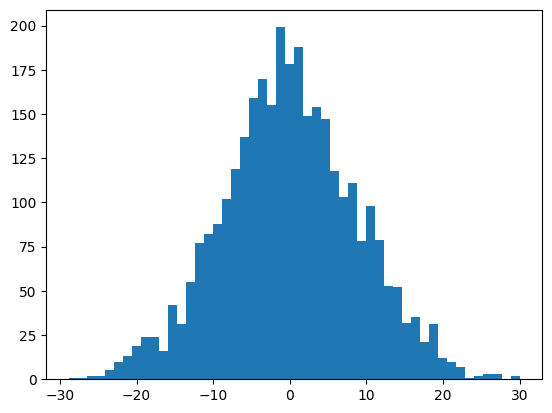

Loss: 3.322859287261963


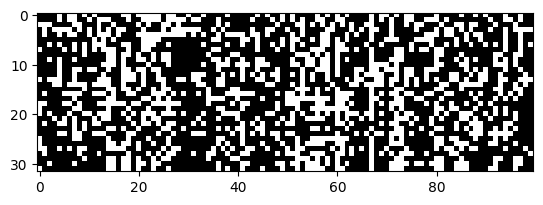

In [24]:
# Training
for epoch in range(EPOCHS):
    # Mini-batch
    i = torch.randint(low=0, high=Y_train.shape[0], size=(batch_size,))
    x_batch = X_train[i]
    y_batch = Y_train[i]

    # Forward
    emb = C[x_batch].view((-1, embedding_dim * context_size))
    out = (emb @ W1 + b1)
    plt.hist(out.flatten().tolist(), bins=50)
    plt.show()
    out = out.tanh()
    plt.imshow(out > 0.99, cmap='gray', interpolation='nearest')
    out = out @ W2 + b2
    loss = F.cross_entropy(out, y_batch)

    # Set grad to zero
    for p in parameters:
        p.grad = None

    # Backpropagation
    loss.backward()

    # Update
    for p in parameters:
        lr = lr if epoch < 10000 else 0.001
        p.data -= lr * p.grad

    print(f"Loss: {loss}")

A good practice is to initialize all the weights inside the network, this is done also for optimizing the gradiant. There a paper written by He that demonstrate that initializing the weights can also produce a good initialization for the gradient. [Here](https://pytorch.org/docs/stable/nn.init.html) are the gain to keep in mind when initializing the weights. For the tahn the gain depends on f_in (the number of input layer) on a constant of 5/3. Weight init also help in reducing the problems related to the saturation of the activation function (but not always solve it), in the next code let's plot for example the distribution of the values before the activation in the first layer

In [25]:
# Parameters
C = torch.randn(27, embedding_dim) # No init needed
W1 = torch.randn(embedding_dim * context_size, hidden_layer_size) * ((5/3) / ((embedding_dim * context_size) ** 0.5)) 
b1 = torch.randn(hidden_layer_size) * 0
W2 = torch.randn(hidden_layer_size, 27) * ((5/3) / (hidden_layer_size ** 0.5)) 
b2 = torch.randn(27) * 0
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

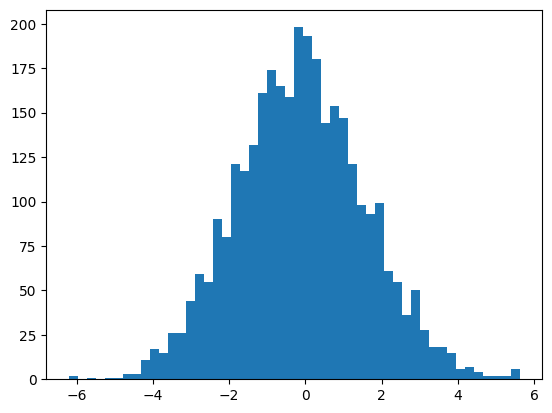

Loss: 4.524530410766602


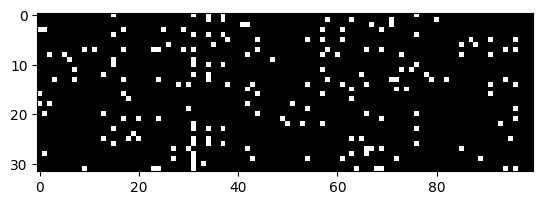

In [26]:
# Training
for epoch in range(EPOCHS):
    # Mini-batch
    i = torch.randint(low=0, high=Y_train.shape[0], size=(batch_size,))
    x_batch = X_train[i]
    y_batch = Y_train[i]

    # Forward
    emb = C[x_batch].view((-1, embedding_dim * context_size))
    out = (emb @ W1 + b1)
    plt.hist(out.flatten().tolist(), bins=50)
    plt.show()
    out = out.tanh()
    plt.imshow(out > 0.99, cmap='gray', interpolation='nearest')
    out = out @ W2 + b2
    loss = F.cross_entropy(out, y_batch)

    # Set grad to zero
    for p in parameters:
        p.grad = None

    # Backpropagation
    loss.backward()

    # Update
    for p in parameters:
        lr = lr if epoch < 10000 else 0.001
        p.data -= lr * p.grad

    print(f"Loss: {loss}")

We will now introduce the batch normalization an operation 

In [27]:
# Parameters
C = torch.randn(27, embedding_dim) # No init needed
W1 = torch.randn(embedding_dim * context_size, hidden_layer_size) * ((5/3) / ((embedding_dim * context_size) ** 0.5)) 
b1 = torch.randn(hidden_layer_size) * 0
shift1 = torch.randn((1, hidden_layer_size))
squeeze1 = torch.randn((1, hidden_layer_size))
W2 = torch.randn(hidden_layer_size, 27) * ((5/3) / (hidden_layer_size ** 0.5)) 
b2 = torch.randn(27) * 0
parameters = [C, W1, b1, shift1, squeeze1, W2, b2]

for p in parameters:
    p.requires_grad = True

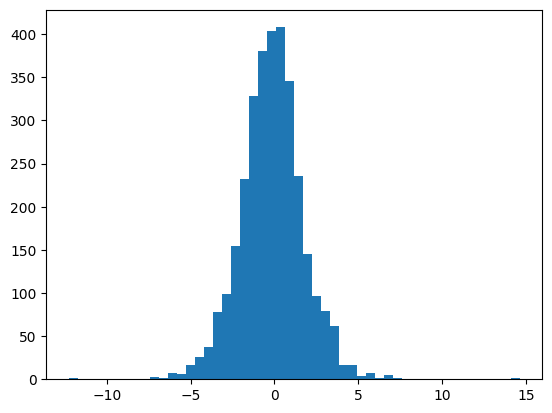

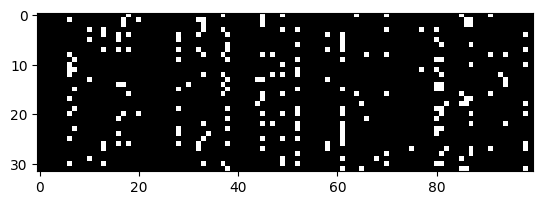

Loss: 3.9846365451812744


In [28]:
# Training
for epoch in range(EPOCHS):
    # Mini-batch
    i = torch.randint(low=0, high=Y_train.shape[0], size=(batch_size,))
    x_batch = X_train[i]
    y_batch = Y_train[i]

    # Forward
    emb = C[x_batch].view((-1, embedding_dim * context_size))
    out = (emb @ W1 + b1)
    out = squeeze1 * (out - out.mean(dim=0, keepdim=True) / out.std(dim=0, keepdim=True)) + shift1
    plt.hist(out.flatten().tolist(), bins=50)
    plt.show()
    out = out.tanh()
    plt.imshow(out > 0.99, cmap='gray', interpolation='nearest')
    plt.show()
    out = out @ W2 + b2
    loss = F.cross_entropy(out, y_batch)

    # Set grad to zero
    for p in parameters:
        p.grad = None

    # Backpropagation
    loss.backward()

    # Update
    for p in parameters:
        lr = lr if epoch < 10000 else 0.001
        p.data -= lr * p.grad

    print(f"Loss: {loss}")

# Visualize Flow of Data

It is important to visualize the flow of information inside the neural network (NN). In particular, two critical factors can indicate whether the parameters of the network are correctly set: parameters and gradients. The parameters need to be correctly initialized, as shown in the previous chapter. However, the problem arises with deeper and deeper networks, where each time we use an activation function, we are typically squeezing the data.

When data passes through an activation function, such as ReLU, sigmoid, or tanh, the output range is often compressed, which can lead to issues like vanishing or exploding gradients. In the case of vanishing gradients, the gradients become very small as they propagate back through the layers, causing the learning process to slow down or stop. Conversely, exploding gradients cause the gradients to become excessively large, potentially leading to unstable training and divergence.

To monitor and mitigate these issues, it is essential to visualize both the parameters and the gradients throughout the training process. This can be done using various techniques:

1. **Histogram of Weights and Biases**: By plotting the distribution of weights and biases for each layer, you can observe how they evolve during training. This helps in detecting issues like weight decay or excessive growth.

2. **Gradient Flow**: Visualizing the gradients of the loss function with respect to the parameters can provide insights into how effectively the network is learning. Gradients that are too small or too large indicate potential problems with the network architecture or learning rate.

3. **Activation Distribution**: Plotting the distribution of activations for each layer can reveal if the network is experiencing dead neurons (e.g., neurons that always output zero with ReLU) or saturation (e.g., neurons that output values near the extremes with sigmoid/tanh).

4. **Learning Curves**: Plotting the training and validation loss over time helps in understanding the overall training process, detecting overfitting, and adjusting hyperparameters.

5. **Layer-wise Output Variance**: Checking the variance of the outputs of each layer can help ensure that the signal is neither diminishing nor amplifying excessively as it moves through the network.

By employing these visualization techniques, you can gain a deeper understanding of how data flows through your network, identify potential issues early, and make informed adjustments to improve the network's performance.

But first let's Pytorchify the previous code:  

In [39]:
Xtr,  Ytr  = X[:n1], Y[:n1]                # 80%
Xdev, Ydev = X[n1:n2], Y[n1:n2]            # 10%
Xte,  Yte  = X[n2], Y[n2:]                 # 10%

In [41]:
# Use as paramter also the vocabulary size
vocab_size = 27
context_size = 3

In [45]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * context_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [46]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2578


layer 2 (      Tanh): mean +0.00, std 0.63, saturated: 3.06%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.62%
layer 8 (      Tanh): mean +0.00, std 0.65, saturated: 2.19%
layer 11 (      Tanh): mean +0.01, std 0.65, saturated: 1.59%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


Text(0.5, 1.0, 'activation distribution')

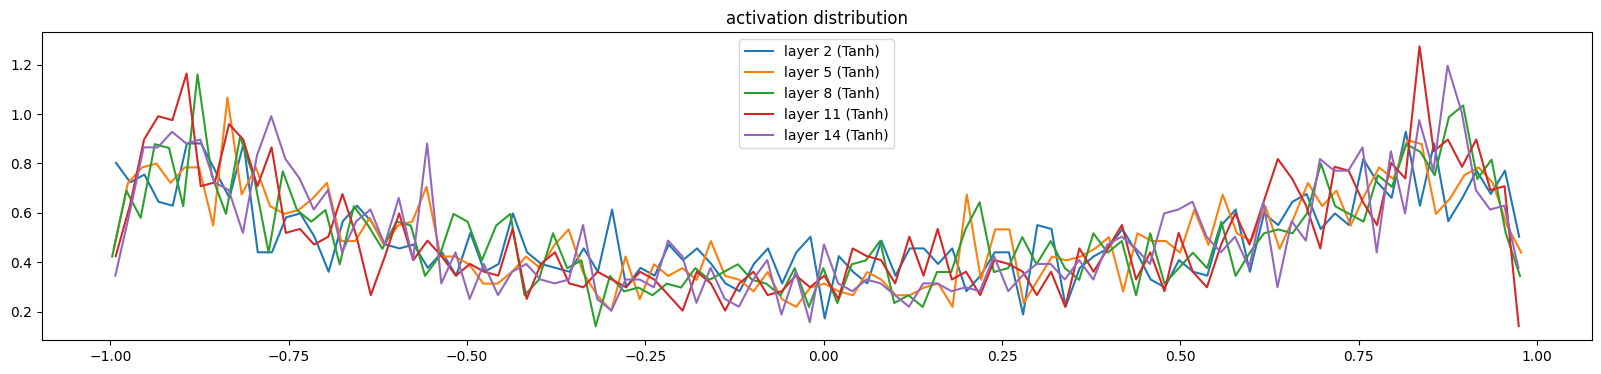

In [48]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 2.745964e-03
layer 5 (      Tanh): mean -0.000000, std 2.306192e-03
layer 8 (      Tanh): mean -0.000000, std 2.159815e-03
layer 11 (      Tanh): mean -0.000000, std 2.050895e-03
layer 14 (      Tanh): mean +0.000000, std 2.075425e-03


Text(0.5, 1.0, 'gradient distribution')

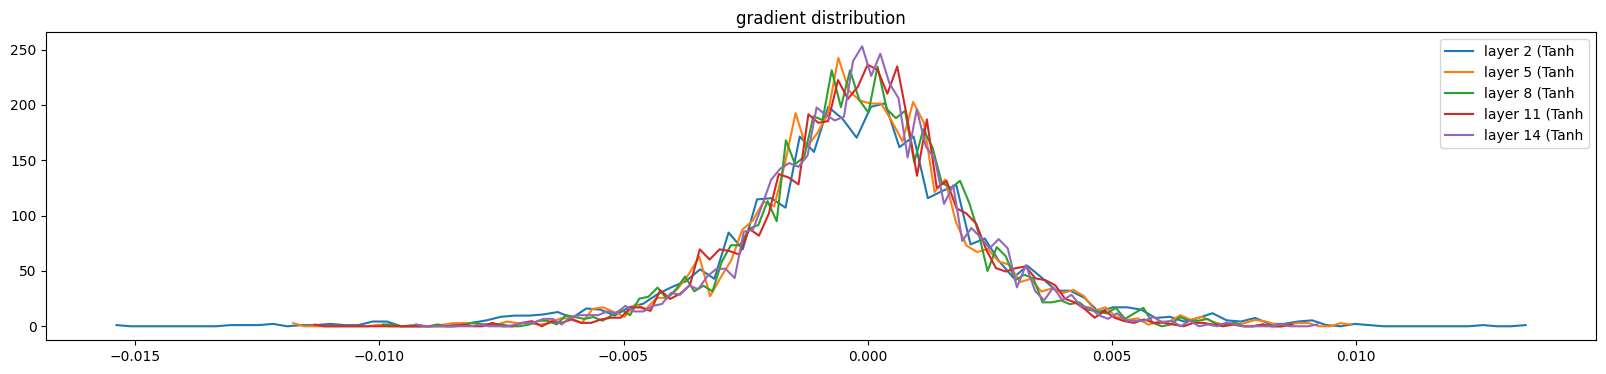

In [49]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 9.922269e-03 | grad:data ratio 9.912289e-03
weight  (30, 100) | mean +0.000069 | std 1.056927e-02 | grad:data ratio 5.580953e-02
weight (100, 100) | mean -0.000014 | std 7.701746e-03 | grad:data ratio 7.529819e-02
weight (100, 100) | mean -0.000050 | std 6.673844e-03 | grad:data ratio 6.505740e-02
weight (100, 100) | mean -0.000013 | std 5.794145e-03 | grad:data ratio 5.687340e-02
weight (100, 100) | mean -0.000072 | std 5.715543e-03 | grad:data ratio 5.616087e-02
weight  (100, 27) | mean +0.000075 | std 1.137511e-02 | grad:data ratio 1.092913e-01


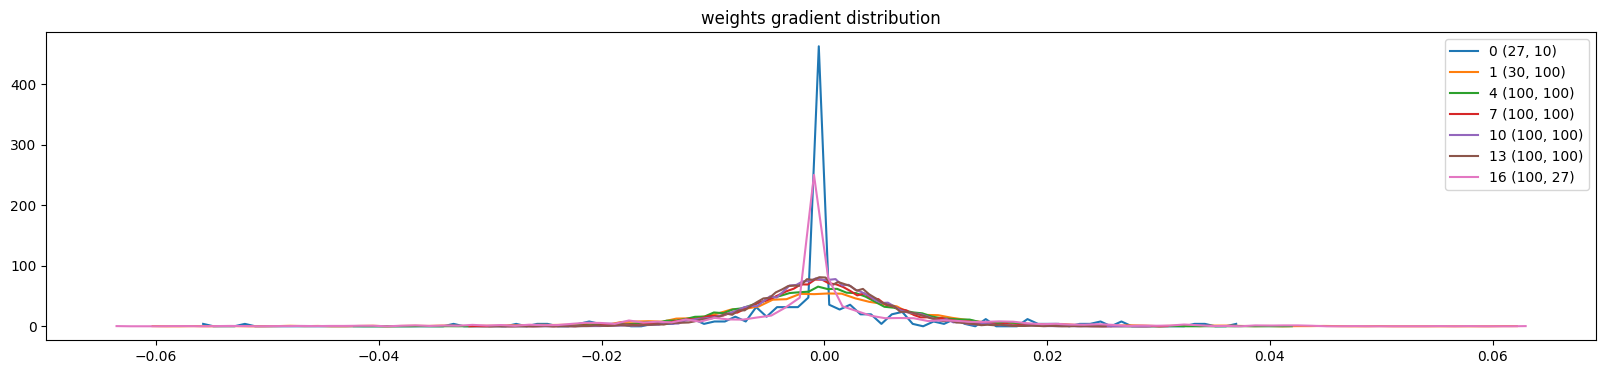

In [50]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

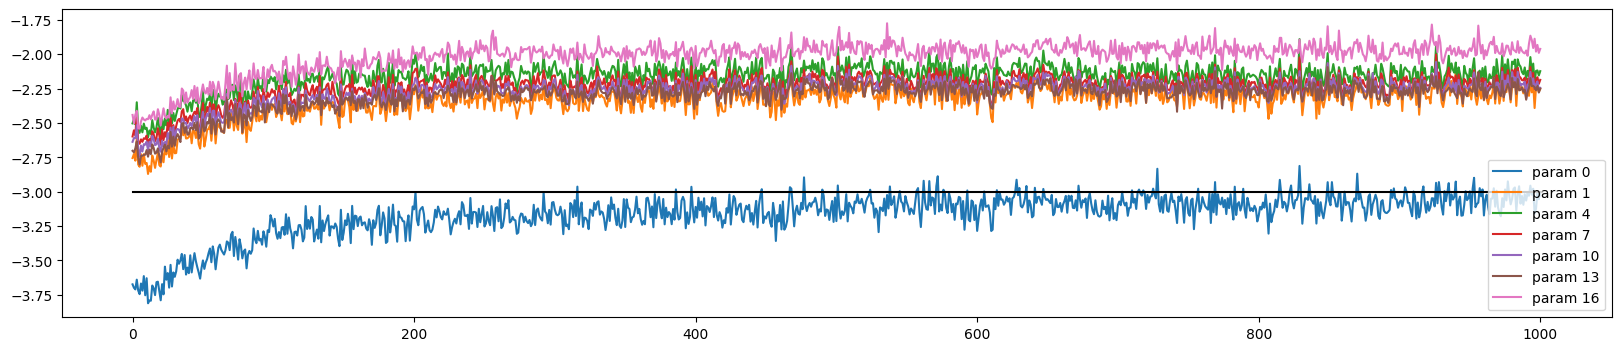

In [51]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [52]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.3454554080963135
val 2.5344178676605225


In [55]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * context_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(decoder[i] for i in out)) # decode and print the generated word

mziahadiqaileta.
friya.
shatanile.
arkara.
smeinretsoni.
dhahta.
tathanee.
bralahna.
disathef.
lirickurioden.
zapera.
zanah.
feexeyax.
maner.
kandrey.
tal.
adeliana.
nil.
ins.
larnenlay.
